# Activations, BatchNorm & Gradients


# Part 1: Calculating Loss after fixing issues

Issues

*   Hockey Stick Loss Reduction - Initially we set our parameters i.e. weights and biases to sample from a normal distribution, which might mean we might have some parameters may take some high extreme value and when we calculate the log likelihood so we have high error or sometime infinity (because of overflow). Moreover, atleast for output layer we have no reason to believe any output is more probable than other. So best way to remidiate this to have uniform distribution like $\frac{1}{classes}$ or 0 for all parameters. Since we want some default solution we can set some small number as 0.01 (for numerical stability) as initial parameter.

*   Saturated Tanh - Any nonliear layer tries to squash the activation value into some range. Now if in our activation value take extreme low or high value, the result of tanh will be -1 or 1 for most activations. This is also the case for other non linearities like sigmoid, relu etc. (not for leaky relu). So the gradients for such training examples will not be backpropagated and if in any of the batch we have all examples with extreme activation the neuron might get permanently damaged. So the remidiation is to squash all the randomly generated initial weights by multiplying with 0.1 so the range of initial weights is not high or low.

*   Kaiming Init - This is a standard way of bringing initial weights into a range where the above issues does not happen. So here we multiply the randomly generated weights by $\frac{gain}{sqrt(fan in)}$, here fainin is the number of connections coming inside that MLP layer, the gain is a scalar value which is different for different non linearities (check here: https://pytorch.org/docs/stable/nn.init.html).

*   Batch Normalization - In this we dont care about how the initial weights were setup, we normalize all the weights after every linear layer of MLP. We do it by updating the each weight as so, x = $\frac{x - mean(x)}{sqrt{(std(x)^2 + epsilon)}}$ and then we need to scale and shift so that backprop updation impacts also the normalization $\alpha$x+$\beta$ where $\alpha$ is tensor of 1s of dimension of layer and $\beta$ is tensor of 0s of dimension of layer, and these tensors are trainable. This also has another good effect of acting as a regulaizer against overfitting. While training the mean and std for batch norm is calculated and is updated slightly is every batch and this is used directly in inference and rest all are trained parameters. As we can see that removing mean and dividing by std takes away the effect of bias of the linear layer, so we dont use bias with linear layer wherever we use batch norm.


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# Read the dataset and show first 8 words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
# Size of dataset
len(words)

32033

In [ ]:
# Building position to character mapping
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# Building the dataset with context length
block_size = 3 # character context for next character prediction, so last 3 character is used to predict next character

def build_dataset(words):
  X, Y = [], []
  for w in words:
    context = [0] * block_size # Initially context start with [0,0,0] which is [...]
    for ch in w + '.': # . is the ending character for each word
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # Rolling - the first character of context is removed and the next character is added from word [...]->[..e]
  X = torch.tensor(X) # context for train [[...], [..e], [.em]], obviously X contains pos not characters
  Y = torch.tensor(Y) # next character pred [e, m, m], obviously Y contains pos not characters
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # Train split - 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # Dev/Val split - 10%
Xte, Yte = build_dataset(words[n2:]) # Test split - 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# Lets define the model layers in torch
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size)**0.5) # Kaiming Init for tanh # * 0.2 # Ch 2: reducing range so that tanh does not deal with extremes
# b1 = torch.randn(n_hidden, generator=g) * 0.01 # Ch 2: reducing range so that tanh does not deal with extremes
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # Ch 1: make weights even
b2 = torch.randn(vocab_size, generator=g) * 0 # Ch 1: make bias even

# Batch Normalization
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

# Batch Normalization parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# List of parameters to optimize
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # Number of paramters in total
for p in parameters:
  p.requires_grad = True

4073


In [ ]:
# Training and Optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # Construct a minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward pass
  emb = C[Xb] # Get the embedding for entire minibatch
  embcat = emb.view(emb.shape[0], -1) # Flatten the embedding, last 2 dimensions of embedding is flattened so its (train_size, context_length)

  # Linear Layer
  hpreact = embcat @ W1 #+ b1 # Calculate the hidden layer pre activation

  # BatchNorm Layer
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # Here batch norm is bit simplified (for no reason :)), ideally you divide by sqrt(std^2+eps)
  with torch.no_grad():
    bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmean
    bn_std_running = 0.999 * bn_std_running + 0.001 * bnstd

  # Non Linearity
  h = torch.tanh(hpreact) # Calculate the hidden layer activation
  logits = h @ W2 + b2 # Calculate the output layer pre activation
  loss = F.cross_entropy(logits, Yb) # Calculate the loss

  # Backward Pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01 # Learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0: # Print every once every 10k steps
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3017
  10000/ 200000: 2.2813
  20000/ 200000: 2.2286
  30000/ 200000: 2.3976
  40000/ 200000: 2.3576
  50000/ 200000: 2.0831
  60000/ 200000: 2.3454
  70000/ 200000: 2.1640
  80000/ 200000: 2.3134
  90000/ 200000: 2.3802
 100000/ 200000: 1.9297
 110000/ 200000: 2.0385
 120000/ 200000: 2.0096
 130000/ 200000: 2.1224
 140000/ 200000: 2.2867
 150000/ 200000: 2.5098
 160000/ 200000: 2.0274
 170000/ 200000: 2.0405
 180000/ 200000: 1.9132
 190000/ 200000: 2.1656


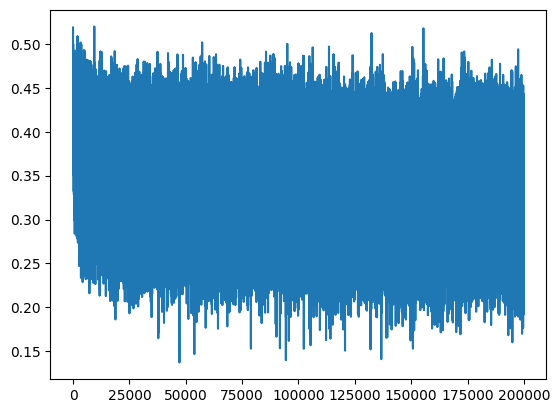

In [ ]:
# Plot the loss
plt.plot(lossi)

In [ ]:
# If you choose to claibrate batch norm paramters at end of training
with torch.no_grad():
  # Pass training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1
  # Measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [ ]:
# Calculate loss for different split after tarining
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (split_size, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (split_size, block_size * n_embd)
  hpreact = embcat @ W1 # + b1 # (split_size, n_hidden)
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias # Need to use when mean/std is calibrated post training
  hpreact = bngain * (hpreact - bn_mean_running) / bn_std_running + bnbias
  h = torch.tanh(hpreact) # (split_size, n_hidden)
  logits = h @ W2 + b2 # (split_size, vocab_size)
  loss = F.cross_entropy(logits, y) # BTW, negative log likelihood of softmax is cross entropy
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.143146514892578
val 2.158292055130005
test 2.1593689918518066


## Results after fixing the issues:

Our losses are higher since we have 64 neurons in hidden layer as opposed to videos 200.

*   Vanilla before any fix losses -
    - Train: 2.1700944900512695
    - Val: 2.1932108402252197
    - Test: 2.18776535987854

*   Hockey stick fix losses -
    - Train: 2.1651318073272705
    - Val: 2.188204288482666
    - Test: 2.1936123371124268

*   Saturated tanh fix losses -
    - Train: 2.130014419555664
    - Val: 2.154247999191284
    - Test: 2.1569347381591797

*   Kaiming Init fix losses -
    - Train: 2.1327221393585205
    - Val: 2.1572885513305664
    - Test: 2.1661500930786133

*   Batch Normalization fix losses -
    - Train: 2.143146514892578
    - Val: 2.158292055130005
    - Test: 2.1593689918518066


# Part 2: Pytorchifying

In [ ]:
# Linear class which defines incoming  and outgoing connections and creates weights and biases on it
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    # fan_in is the input connections and fan_out is the total number of neurons
    self.weight = torch.randn((fan_in, fan_out), generator=g) # / fan_in**0.5 # Use this if no batch norm
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [ ]:
# Batch Norm class which defines the gamma and beta parameters based on dimensions which is generally preceding linear layer fanout dim, we also track running mean and std so that
# it can be used during inference. While training batch mean and std is used for batch normalization of weight of previous linear layer
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim) # alpha we mentioned above for batch norm
    self.beta = torch.zeros(dim) # beta we mentioned above for batch norm
    # Buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdim=True) # Batch mean
      xvar = x.var(0, keepdim=True) # Batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize
    self.out = self.gamma * xhat + self.beta
    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [ ]:
# Tanh class which defines non linearity function, this has no parameters, just application of non linearity on activations
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [ ]:
# Lets create the model layers using the classes deined above
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)
# With Batch Norm applied
layers = [
  Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# Without Batch Norm applied
# layers = [
#   Linear(n_embed * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]
# Applying gains to linear layers
with torch.no_grad():
  layers[-1].gamma *= 0.1 # gamma applied instead of weight since now last non linear layer is that of batch norm
  # layers[-1].weight *= 0.1 # For output layer, make it less confident by uniforming it out a bit
  for layer in layers[:-1]: # All but last
    if isinstance(layer, Linear):
      layer.weight *= 1 # No gain needed during batch norm # *= 5/3 # Apply the gain based on Kaiming Init for tanh

# Getting all the parameters of the model
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

# Make all parameters trainable
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# Training and Optimization
max_steps = 200000
batch_size = 32
lossi = [] # Stores the loss after every step
ud = [] # Store the updates ratios for every step

for i in range(max_steps):

  # Construct a minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # Forward pass
  emb = C[Xb] # Get the embedding for entire minibatch
  embcat = emb.view(emb.shape[0], -1) # Flatten the embedding, last 2 dimensions of embedding is flattened so its (train_size, context_length)

  # Linear Layer
  for layer in layers: # For each of the layer __call__ is called so linear, batchnorm(optional), tanh is called successcively
    embcat = layer(embcat)
  loss = F.cross_entropy(embcat, Yb) # Calculate the loss

  # Backward Pass
  for layer in layers:
    layer.out.retain_grad() # After Debug: Remove this
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  # lr = 0.1 if i < 150000 else 0.01 # Learning rate decay
  lr = 1.0 if i < 100000 else 0.1 # Learning rate decay with batch norm
  for p in parameters:
    p.data += -lr * p.grad

  # Track stats
  if i % 10000 == 0: # Print every once every 10k steps
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # After Debug: Remove this

      0/ 200000: 3.2870


# Part 3: Diagnostic Tools on Training

layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 3.91%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.53%
layer 8 (      Tanh): mean -0.02, std 0.63, saturated: 3.09%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 2.69%
layer 14 (      Tanh): mean +0.02, std 0.64, saturated: 3.34%


Text(0.5, 1.0, 'Activation Distribution')

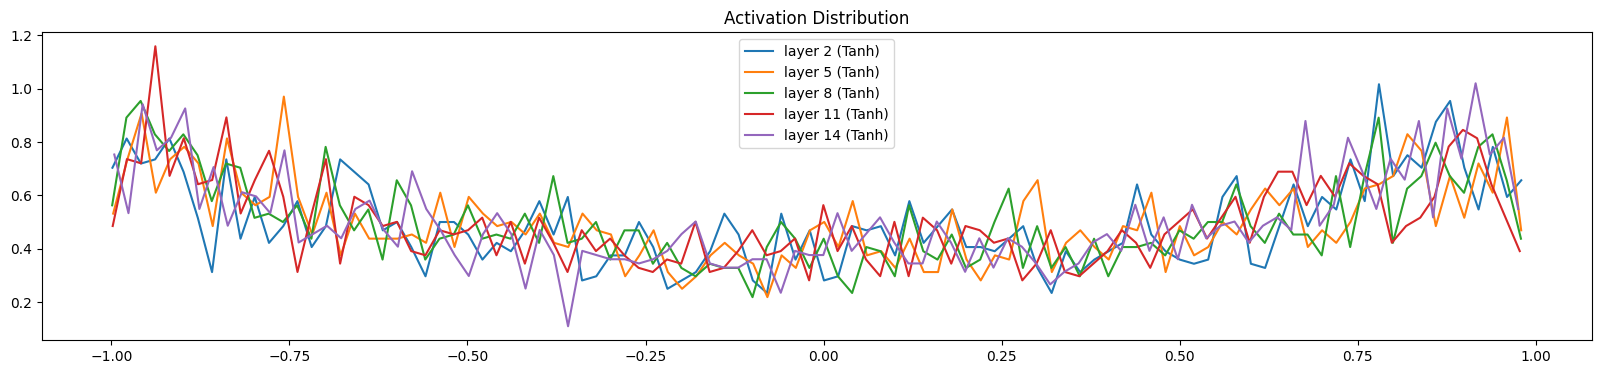

In [ ]:
# Visualizing the Saturation in Tanh layer (With Batch Norm)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out # Getting the output of each tanh layer
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) # More than 0.97 is saturated
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')
# Observation: So the saturation look fine, we dont need fanin product in linear layer, as well as no gain is needed.

layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'Activation Distribution')

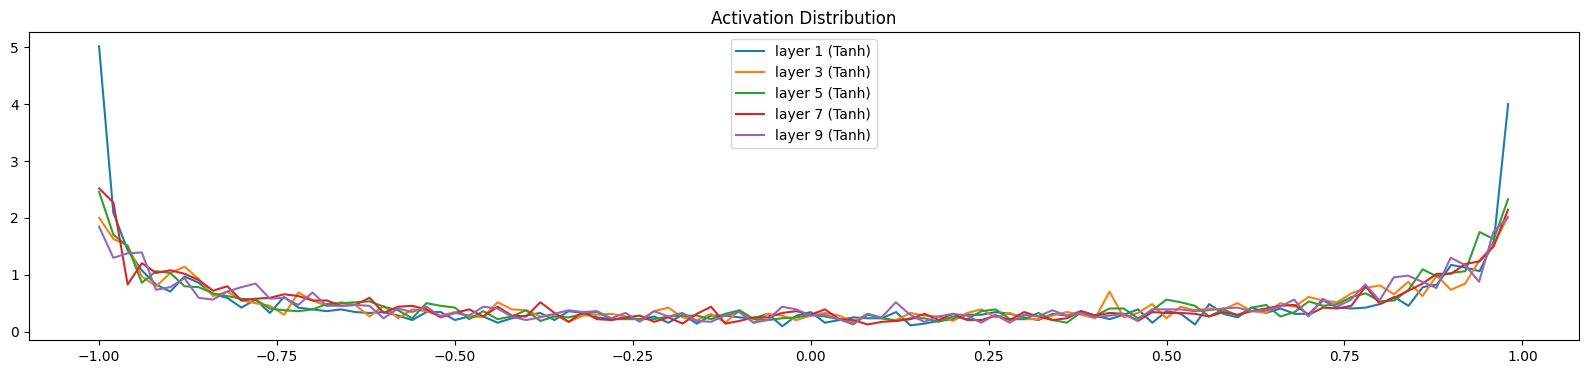

In [ ]:
# Visualizing the Saturation in Tanh layer [Dont Run this]
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out # Getting the output of each tanh layer
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100)) # More than 0.97 is saturated
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')
# Observation: So we dont want highly saturated layer since it causes gradients to not pass, while if the gain (current=5/3) is small like 1, since tanh squashed between -1 to 1 it will move saturation to 0

layer 2 (      Tanh): mean -0.000000, std 4.081716e-03
layer 5 (      Tanh): mean -0.000000, std 3.513452e-03
layer 8 (      Tanh): mean +0.000000, std 3.458265e-03
layer 11 (      Tanh): mean +0.000000, std 3.407235e-03
layer 14 (      Tanh): mean -0.000000, std 3.295505e-03


Text(0.5, 1.0, 'Gradient Distribution')

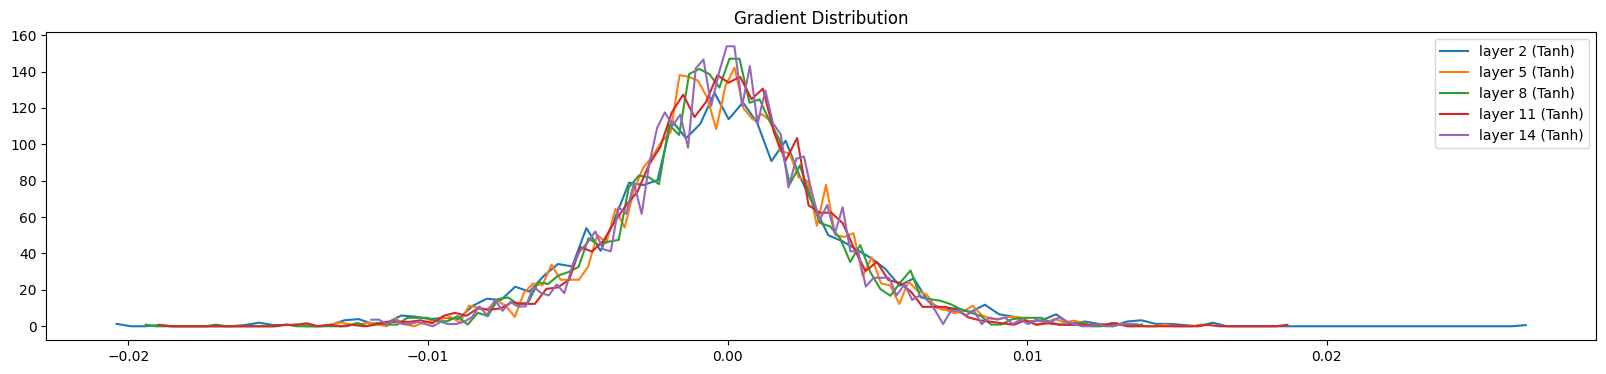

In [ ]:
# Visualizing Gradients (With Batch Norm)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad # Getting the gradient at end of each layer
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')
# Observation: We dont see diminishing or exploding gradients

layer 1 (      Tanh): mean +0.000024, std 3.353992e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'Gradient Distribution')

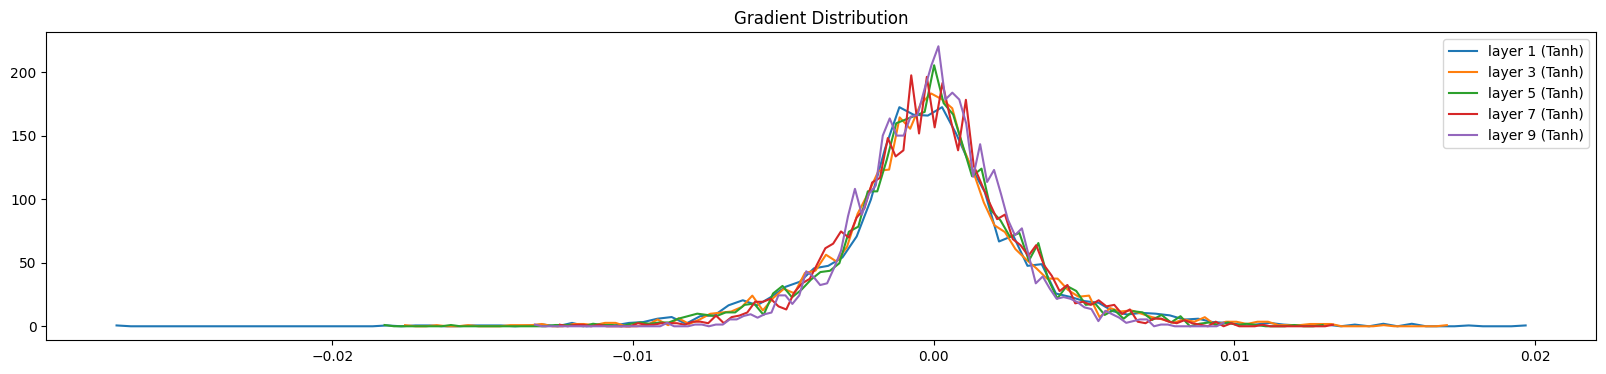

In [ ]:
# Visualizing Gradients [Dont Run this]
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad # Getting the gradient at end of each layer
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Gradient Distribution')
# Observation: We dont see diminishing or exploding gradients

weight   (27, 10) | mean +0.000000 | std 8.340198e-03 | grad:data ratio 8.083646e-03
weight  (30, 100) | mean +0.000061 | std 2.610464e-03 | grad:data ratio 2.540101e-03
weight (100, 100) | mean -0.000013 | std 1.353517e-03 | grad:data ratio 1.356913e-03
weight (100, 100) | mean -0.000005 | std 1.178781e-03 | grad:data ratio 1.169537e-03
weight (100, 100) | mean -0.000005 | std 1.124871e-03 | grad:data ratio 1.120831e-03
weight (100, 100) | mean +0.000006 | std 1.150514e-03 | grad:data ratio 1.145344e-03
weight  (100, 27) | mean -0.000025 | std 2.196452e-03 | grad:data ratio 2.218109e-03


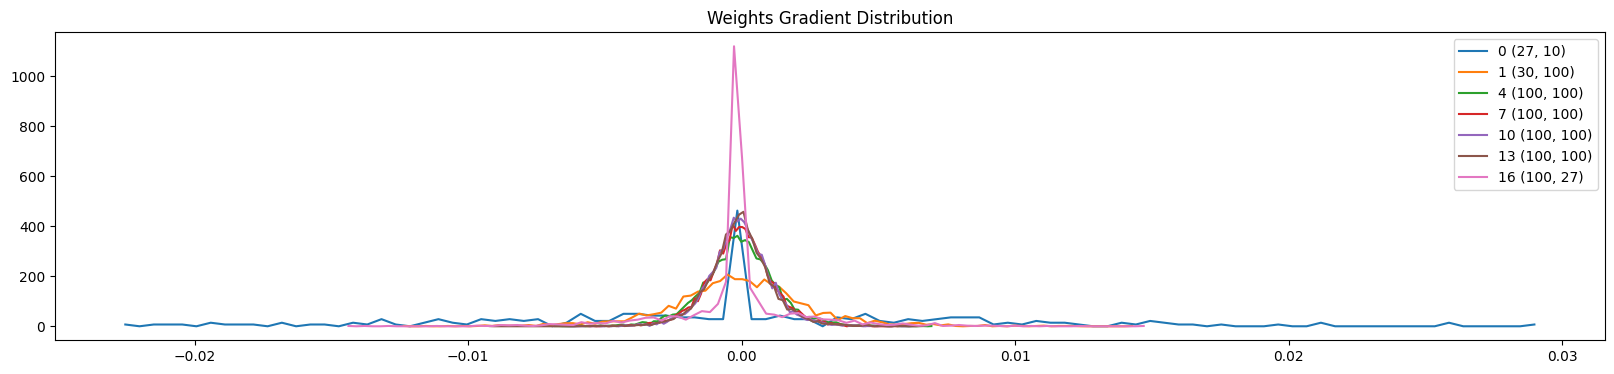

In [ ]:
# Visualizing Linear layer weight grads (With Batch Norm)
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Only getting linear layer since
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())) # Mean and std of grad and then ratio of grad std to data std
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');
# Observation: grad std/data std ratio is similar as grad to data, the troubling thing is the last layer where ratio is higher, which can be fixed using AdamW as opposed to SGD

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214556e-02
weight (100, 100) | mean +0.000033 | std 7.821212e-03 | grad:data ratio 4.653362e-02
weight (100, 100) | mean -0.000107 | std 6.655620e-03 | grad:data ratio 3.925851e-02
weight (100, 100) | mean -0.000017 | std 6.086041e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


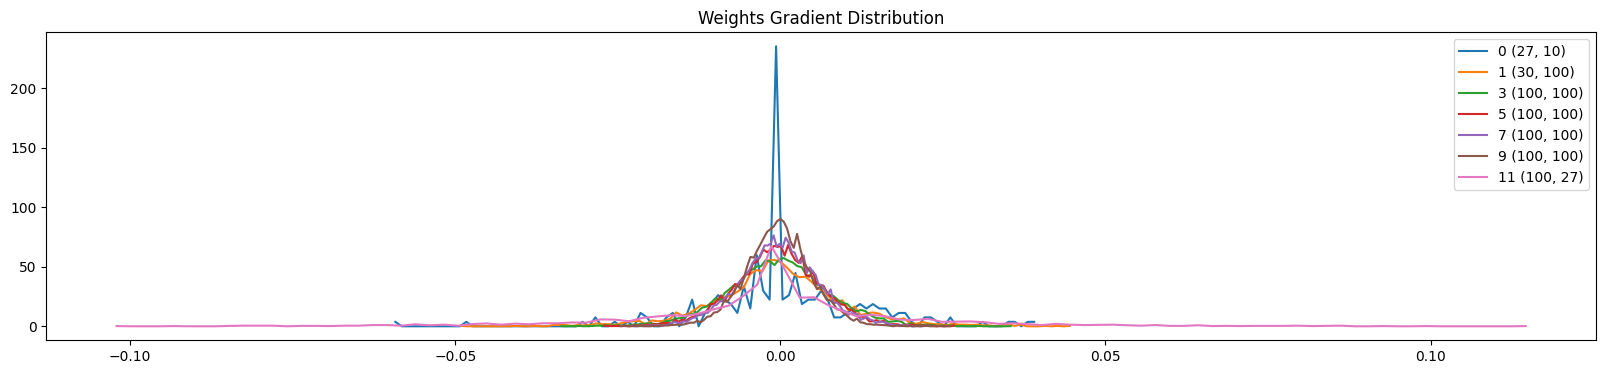

In [ ]:
# Visualizing Linear layer weight grads [Dont Run this]
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Only getting linear layer since
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std())) # Mean and std of grad and then ratio of grad std to data std
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distribution');
# Observation: grad std/data std ratio is similar as grad to data, the troubling thing is the last layer where ratio is higher, which can be fixed using AdamW as opposed to SGD

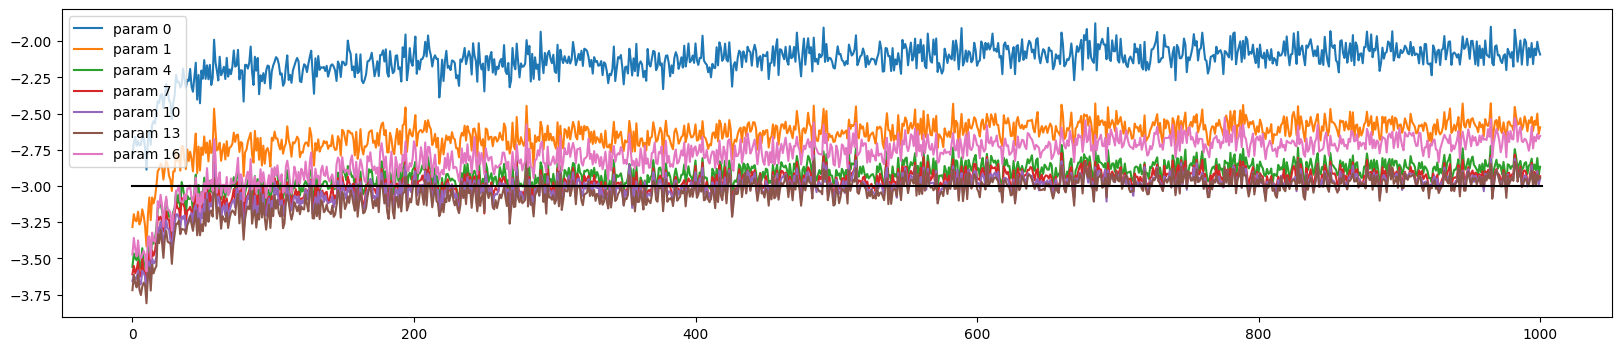

In [ ]:
# Visualizing the updates ratios on the weights (With Batch Norm)
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 (10^-3), indicate on plot
plt.legend(legends);
# Observation:  The black straight line shows what should be the ideal value, the last layer looks like outlier since we made it less confident by multiplying 0.1 but slowing its
# moving towards the black line. We dont generally want updation below black line, this means that the learning is slow and this can happen because of low learning rate

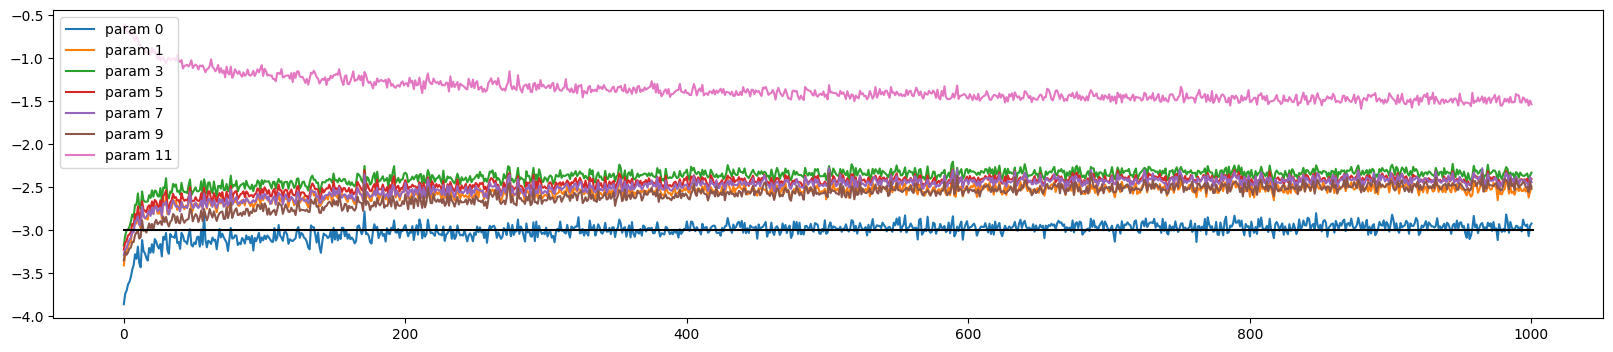

In [ ]:
# Visualizing the updates ratios on the weights [Dont Run this]
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3 (10^-3), indicate on plot
plt.legend(legends);
# Observation:  The black straight line shows what should be the ideal value, the last layer looks like outlier since we made it less confident by multiplying 0.1 but slowing its
# moving towards the black line. We dont generally want updation below black line, this means that the learning is slow and this can happen because of low learning rate

In [ ]:
# Calculate loss for different split after tarining (With Batch Norm)
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (split_size, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (split_size, block_size * n_embd)
  for layer in layers:
    embcat = layer(embcat)
  loss = F.cross_entropy(embcat, y) # BTW, negative log likelihood of softmax is cross entropy
  print(split, loss.item())

for layer in layers: # Put in eval mode
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 2.4127321243286133
val 2.4115982055664062
test 2.416755199432373


In [ ]:
# Calculate loss for different split after tarining [Dont Run this]
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (split_size, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (split_size, block_size * n_embd)
  for layer in layers:
    embcat = layer(embcat)
  loss = F.cross_entropy(embcat, y) # BTW, negative log likelihood of softmax is cross entropy
  print(split, loss.item())

for layer in layers: # Put in eval mode
  layer.training = False
split_loss('train')
split_loss('val')
split_loss('test')

train 2.366689682006836
val 2.374152183532715
test 2.3724796772003174
